# Gap Statistic

In [20]:
# Gap Statistic Method

# Imports from package
import gap_statistic as gs

# Imports for demo
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import style
style.use('ggplot')

In [28]:
# Generate data
X, y = make_blobs(400, centers=4)

In [29]:
# Generate cluster labels
labels_list = []
clusterers = []
for n_clusters in range(1, 10):
    clusterer = KMeans(init='k-means++', n_clusters=n_clusters)
    labels_list.append(clusterer.fit_predict(X))
    clusterers.append(clusterer)

In [25]:
# Get gap statistics
ks, Wks, Wkbs, sk = gs.gap_statistic(X, labels_list, clusterers)

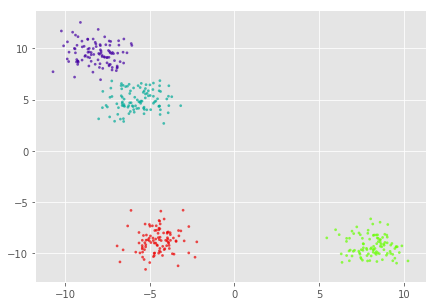

In [30]:
fig, ax = plt.subplots(1, figsize=(7, 5))
colors = cm.spectral((y + 0.5).astype(float) / len(np.unique(y)))     
ax.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
plt.show()

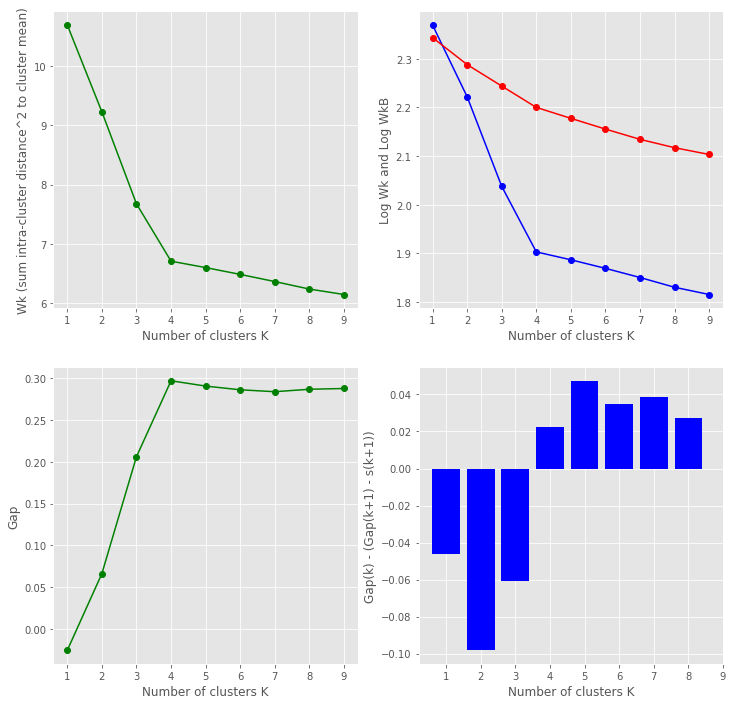

In [31]:
# Or just plot it (typically this will be what you want to see)
gs.graph_gap_statistic(X, labels_list, clusterers)